# Model 1 TensorFlow

In this notebook we will: 
* visualize MRI images
* preprocess our data
* experiment with CNNs

In [1]:
import os
#walk through our data directory using the os.walk
your_data_path = "chest_xray"
for dirpath, dirnames, filenames in os.walk(your_data_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' .")

There are 4 directories and 1 images in 'chest_xray' .
There are 2 directories and 0 images in 'chest_xray/test' .
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA' .
There are 0 directories and 234 images in 'chest_xray/test/NORMAL' .
There are 3 directories and 1 images in 'chest_xray/chest_xray' .
There are 2 directories and 1 images in 'chest_xray/chest_xray/test' .
There are 0 directories and 390 images in 'chest_xray/chest_xray/test/PNEUMONIA' .
There are 0 directories and 234 images in 'chest_xray/chest_xray/test/NORMAL' .
There are 2 directories and 1 images in 'chest_xray/chest_xray/train' .
There are 0 directories and 3876 images in 'chest_xray/chest_xray/train/PNEUMONIA' .
There are 0 directories and 1342 images in 'chest_xray/chest_xray/train/NORMAL' .
There are 2 directories and 1 images in 'chest_xray/chest_xray/val' .
There are 0 directories and 9 images in 'chest_xray/chest_xray/val/PNEUMONIA' .
There are 0 directories and 9 images in 'chest_xray/che

## Data Preprocessing
### Let's create a function that plots random images of our dataset

In [2]:
#Lets visualize images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    #setuop target directory
    target_folder = target_dir + target_class

    #get random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    #read tha image and plot it
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}")

    return img

Image shape: (2025, 2338)


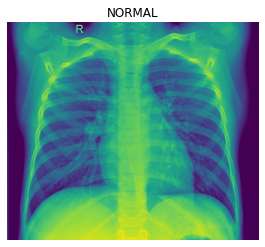

In [12]:
img = view_random_image(target_dir= your_data_path + "/train/",
                        target_class = "NORMAL")

Image shape: (1048, 1472)


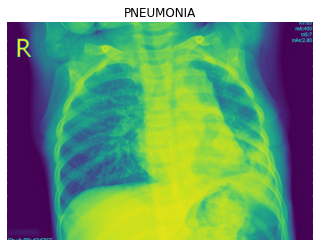

In [13]:
img = view_random_image(target_dir= your_data_path + "/train/",
                        target_class = "PNEUMONIA")

### Setting up training and validation data

Using the `ImageDataGenerator` method we normalize our images

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#tf.random.set_seed(42) #set random seed for reproducability

#normalizing the data

train_datagen = ImageDataGenerator(rescale = 1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

#setup paths to data directories
train_dir = your_data_path + "/train"
valid_dir = your_data_path + "/val"
test_dir = your_data_path + "/test"

#import data from directoriess and turn them into batches

train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory = valid_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "binary",
                                               seed=42)
test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "binary",
                                               seed=42)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
#Build a CNN (like Tiny VGG on CNN explainer website)

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters =10,
                          kernel_size =3,
                          activation = "relu",
                          input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3,activation="relu"),#these 2 layers are the same
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding = 'valid'),
    tf.keras.layers.Conv2D(10,3,activation="relu"),
    tf.keras.layers.Conv2D(10,3,activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

#Compile our CNN
model_1.compile(loss = "binary_crossentropy",
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#fit the model
history_1 = model_1.fit(train_data,
                        epochs=2,
                        steps_per_epoch =len(train_data),
                        validation_data = valid_data,
                        validation_steps =len(valid_data))


Train for 163 steps, validate for 1 steps
Epoch 1/2
163/163 [==============================] - 534s 3s/step - loss: 0.4595 - accuracy: 0.7743 - val_loss: 0.7857 - val_accuracy: 0.5000
Epoch 2/2
163/163 [==============================] - 561s 3s/step - loss: 0.3757 - accuracy: 0.8169 - val_loss: 1.2860 - val_accuracy: 0.5000


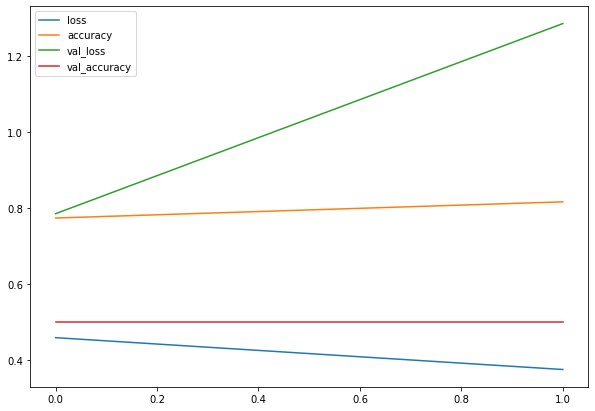

In [18]:
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10, 7));

In [19]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

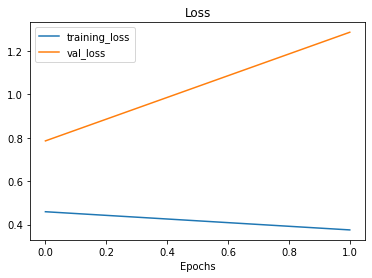

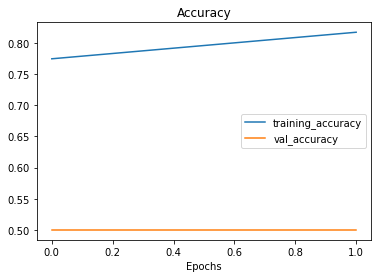

In [20]:
plot_loss_curves(history_1)